# File and libraries

In [91]:
import pandas as pd
import numpy as np




filepath=r'dataset/df_ecom_2_6_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Multicategory Online Store"

# DSLabs functions

In [90]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [75]:
%run "data_functions.py"


data_functions loaded


# Load

In [92]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    df = df.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
    
else:
    df=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    # data=pd.read_csv(sample_filepath)
    # test= pd.read_csv(test_sample_filepath)
    # train= pd.read_csv(train_sample_filepath)
 
target='is_purchase'
eval_metric_1='precision'
eval_metric_2='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)
test.sort_values(by='day', inplace=True)
train.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188630 entries, 0 to 188629
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   price                188630 non-null  float64
 1   is_purchase          188630 non-null  int64  
 2   activity_in_session  188630 non-null  float64
 3   week_of_month        188630 non-null  int64  
 4   is_weekend           188630 non-null  int64  
 5   day                  188630 non-null  int64  
 6   brand_value          188630 non-null  float64
 7   time_of_day_sin      188630 non-null  float64
 8   time_of_day_cos      188630 non-null  float64
 9   day_of_week_sin      188630 non-null  float64
 10  day_of_week_cos      188630 non-null  float64
 11  hour_sin             188630 non-null  float64
 12  hour_cos             188630 non-null  float64
 13  min_sin              188630 non-null  float64
 14  min_cos              188630 non-null  float64
dtypes: float64(11), int64(

# Distribution Check

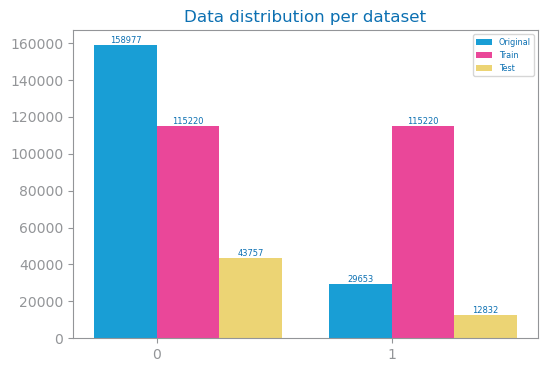

In [93]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(df[df[target] == 0]),  # Assuming 0 is the negative class
        len(df[df[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# Model Evaluation

In [8]:

from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# adapted to read from memory
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Reads training and test data from either CSV files or DataFrames, and splits
    the data into features and target.

    Parameters:
    -----------
    train_fn : Union[str, DataFrame]
        File path to the training CSV or a DataFrame object.
    test_fn : Union[str, DataFrame]
        File path to the test CSV or a DataFrame object.
    target : str, default="class"
        The name of the target column.

    Returns:
    --------
    tuple : (trnX, tstX, trnY, tstY, labels, features)
        - trnX: Training feature set as ndarray.
        - tstX: Test feature set as ndarray.
        - trnY: Training labels as array.
        - tstY: Test labels as array.
        - labels: List of unique target values.
        - features: List of feature names (column names).
    """
    # Check if train_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Use the provided DataFrame directly

    # Extract and sort unique target labels
    labels: list = list(train[target].unique())
    labels.sort()

    # Separate features (X) and target (Y) for training data
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Check if test_fn is a string (file path) or DataFrame, and handle accordingly
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Use the provided DataFrame directly

    # Separate features (X) and target (Y) for test data
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()



In [94]:
from typing import Union
import pandas as pd
from pandas import DataFrame
from numpy import array, ndarray

# Função para ler os dados de treino e teste
def read_train_test_from_files(
    train_fn: Union[str, DataFrame], test_fn: Union[str, DataFrame], target: str = "class"
) -> tuple[ndarray, ndarray, array, array, list, list]:
    """
    Lê dados de treino e teste de arquivos CSV ou DataFrames e separa as características e o alvo.

    (Documentação da função...)
    """
    # Verificar se train_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(train_fn, str):
        train: DataFrame = pd.read_csv(train_fn, index_col=None)
    else:
        train: DataFrame = train_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Extrair e ordenar os rótulos de alvo únicos
    labels: list = list(train[target].unique())
    labels.sort()

    # Separar características (X) e alvo (Y) para dados de treino
    trnY: array = train.pop(target).to_list()
    trnX: ndarray = train.values

    # Verificar se test_fn é uma string (caminho do arquivo) ou DataFrame, e tratar conforme necessário
    if isinstance(test_fn, str):
        test: DataFrame = pd.read_csv(test_fn, index_col=None)
    else:
        test: DataFrame = test_fn.copy()  # Usar o DataFrame fornecido diretamente

    # Separar características (X) e alvo (Y) para dados de teste
    tstY: array = test.pop(target).to_list()
    tstX: ndarray = test.values

    return trnX, tstX, trnY, tstY, labels, train.columns.to_list()

# Exemplo de uso da função
if evaluate == True:
    # Verifica o tipo de train e test
    print(f'Train: {train}, type: {type(train)}')  # Verifica o tipo de train
    print(f'Test: {test}, type: {type(test)}')      # Verifica o tipo de test

    # Lê os dados usando a função
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)

    # Exibe as informações lidas
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')


Train:          price  activity_in_session  week_of_month  is_weekend   day  \
0       261.55             3.000000            2.0         0.0   8.0   
6151    739.79             4.000000            2.0         0.0   8.0   
6152    463.07             2.000000            2.0         0.0   8.0   
6153    306.31             3.000000            2.0         0.0   8.0   
6154    463.31             3.000000            2.0         0.0   8.0   
...        ...                  ...            ...         ...   ...   
190128  958.32             2.000000            3.0         1.0  17.0   
190129  128.42             2.000000            3.0         1.0  17.0   
190130  328.25             1.000000            3.0         1.0  17.0   
190118  259.98             4.000000            3.0         1.0  17.0   
230439  939.54             4.572483            3.0         1.0  17.0   

        brand_value  time_of_day_sin  time_of_day_cos  day_of_week_sin  \
0             455.0            0.624           -0.781 

In [95]:
if evaluate==True:
    
    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

Train#=230440 Test#=56589
Labels=[0, 1]


## d max definition

In [96]:
d_max_eval= 10

## recall evaluation

DT best with gini and d=4


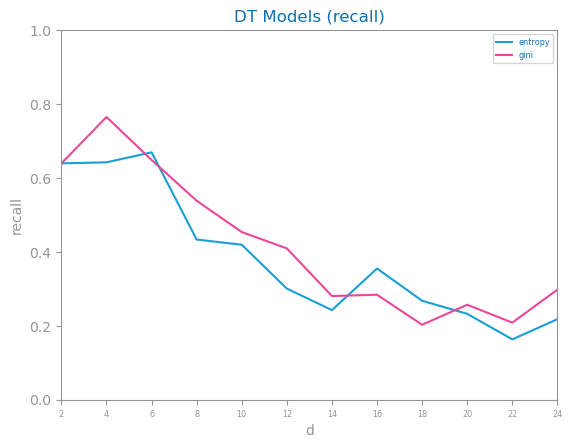

In [82]:
if evaluate==True:

    best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='recall')
    savefig(f'images/{file_tag}_dt_recall_study.png')
    show()

DT best with gini and d=6


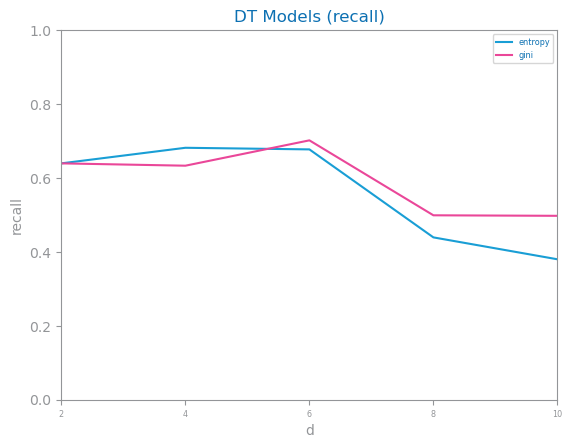

In [83]:
best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='recall')
savefig(f'images/{file_tag}_dt_recall_study.png')
show()

<Figure size 640x480 with 0 Axes>

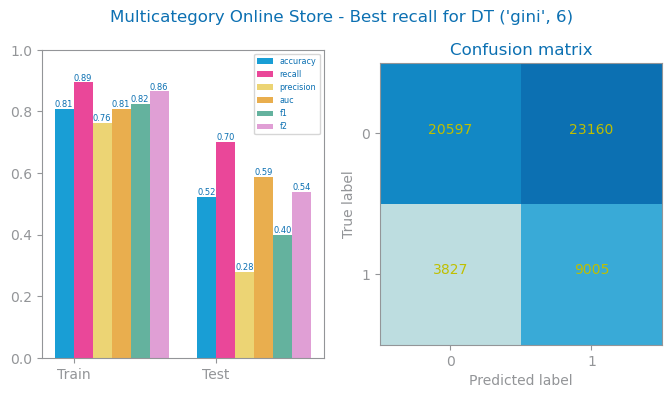

In [97]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## evaluate precision

DT best with entropy and d=2


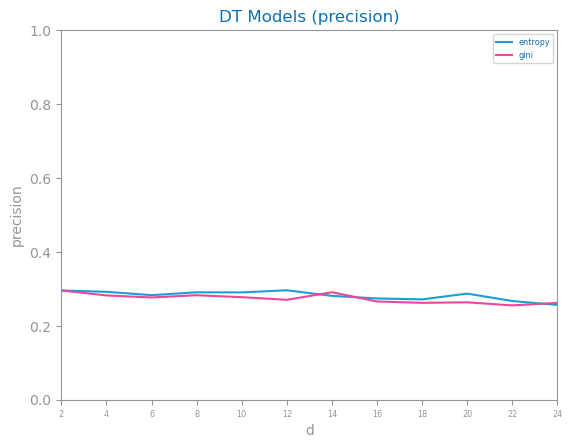

In [98]:
if evaluate==True:

    best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric='precision')
    savefig(f'images/{file_tag}_dt_precision_study.png')
    show()

<Figure size 640x480 with 0 Axes>

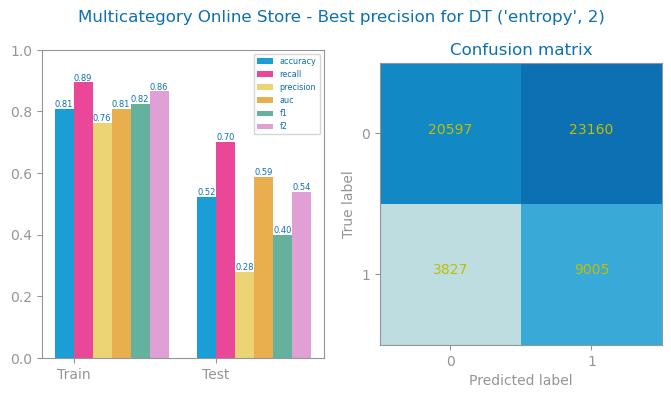

In [99]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## evaluate f2

DT best with entropy and d=6


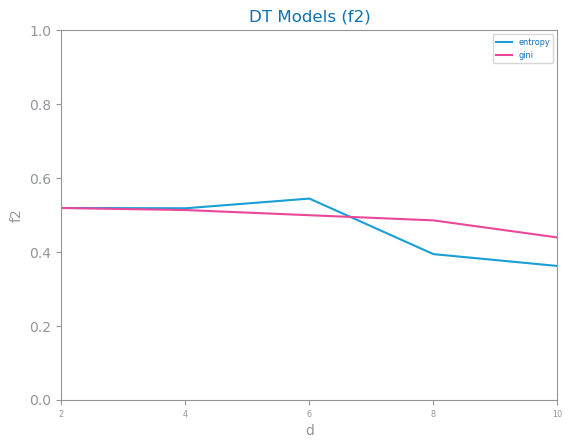

In [102]:
best_model_f2, f2_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='f2')
savefig(f'images/{file_tag}_dt_{f2_params["metric"]}_study.png')
show()

<Figure size 640x480 with 0 Axes>

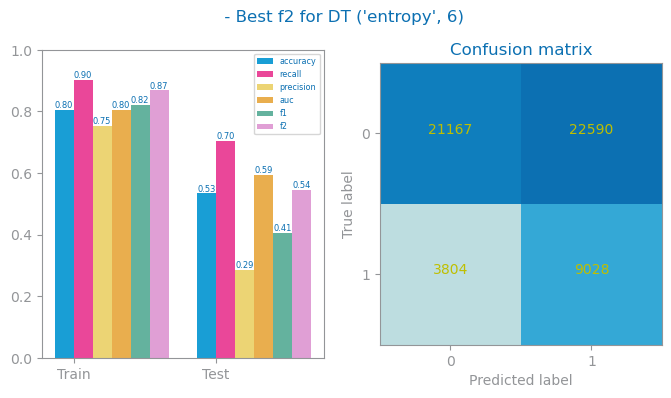

In [103]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_knn_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## Evaluate for best model - Decision Trees

DT best with gini and d=6


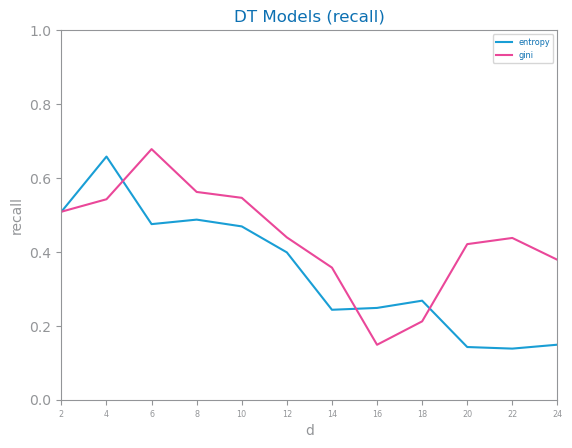

In [38]:
if evaluate==True:

    figure()

    eval_metric = 'recall'

    best_model, params = trees_study(trnX, trnY, tstX, tstY, d_max=25, metric=eval_metric)
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()

# Best Model Performance

<Figure size 640x480 with 0 Axes>

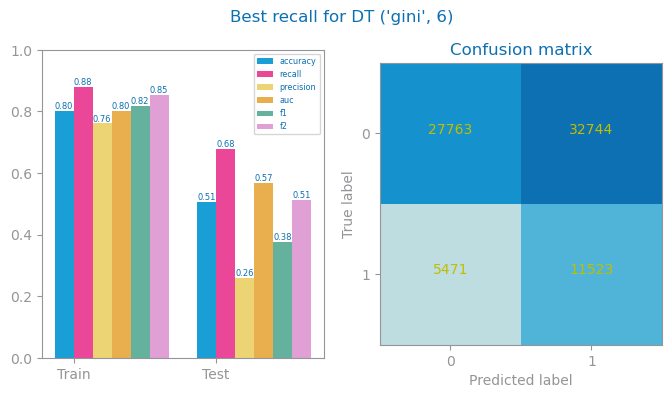

In [40]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

## Variables importance

# IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ

1. open conda terminal
2. conda install graphviz

### f2 tree evaluation

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.945547 to fit


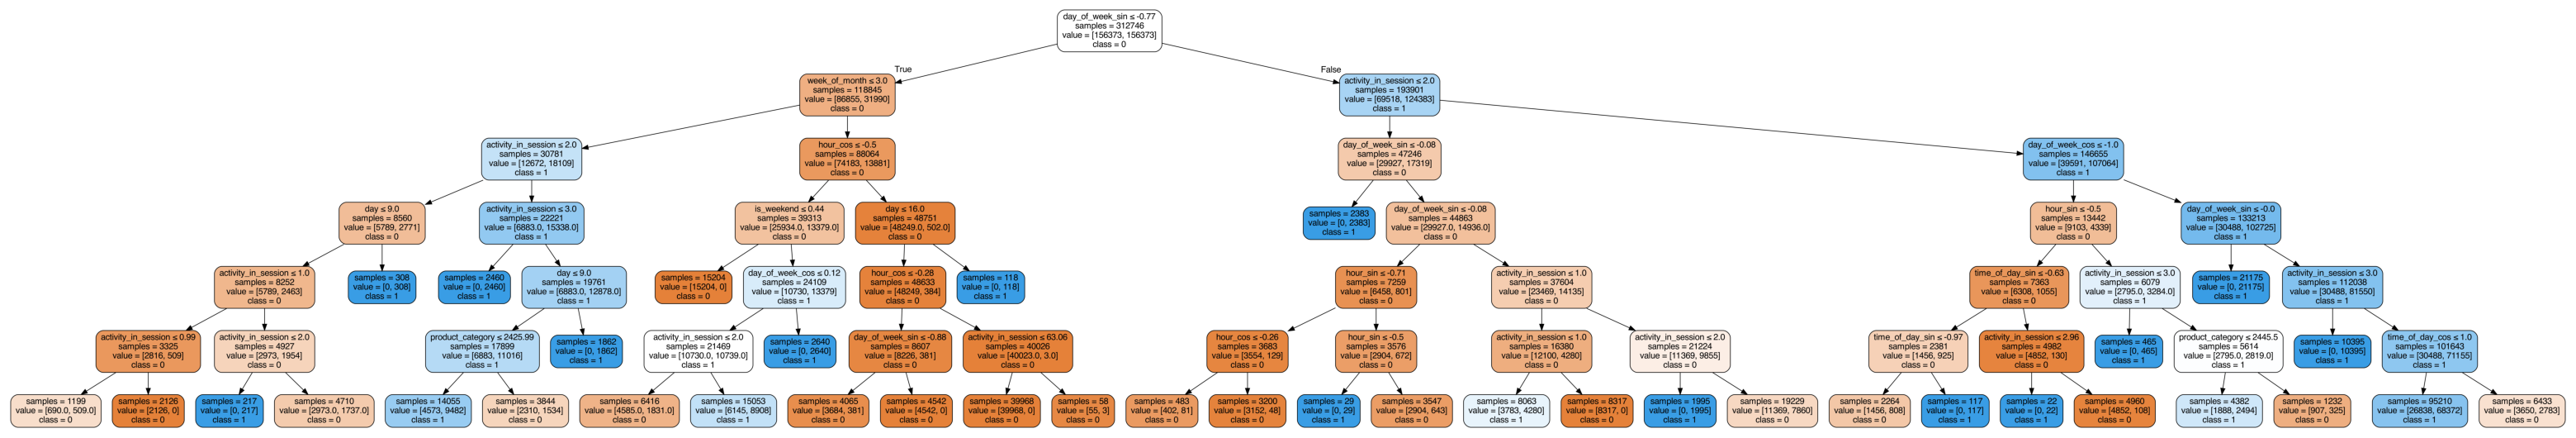

In [47]:
if evaluate==True:
    from sklearn.tree import export_graphviz
    from matplotlib.pyplot import imread, imshow, axis
    from subprocess import call

    tree_filename: str = f"images/{file_tag}_dt_{eval_metric}_best_tree"
    max_depth2show = 8
    st_labels: list[str] = [str(value) for value in labels]

    dot_data: str = export_graphviz(
        best_model,
        out_file=tree_filename + ".dot",
        max_depth=max_depth2show,
        feature_names=vars,
        class_names=st_labels,
        filled=True,
        rounded=True,
        impurity=False,
        special_characters=True,
        precision=2,
    )
    # Convert to png
    call(
        ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
    )

    figure(figsize=(40, 30))
    imshow(imread(tree_filename + ".png"))
    axis("off")
    show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.939771 to fit


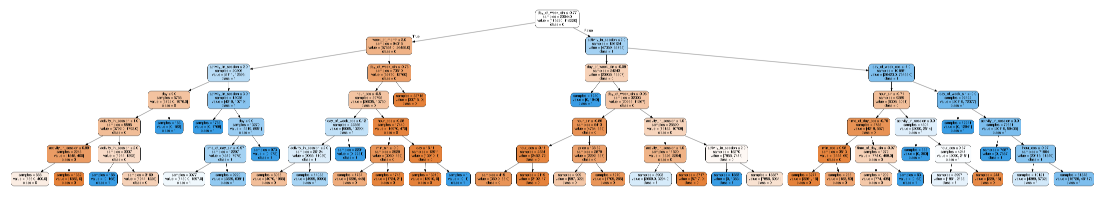

In [105]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{f2_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_f2,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

## f2 simpler tree

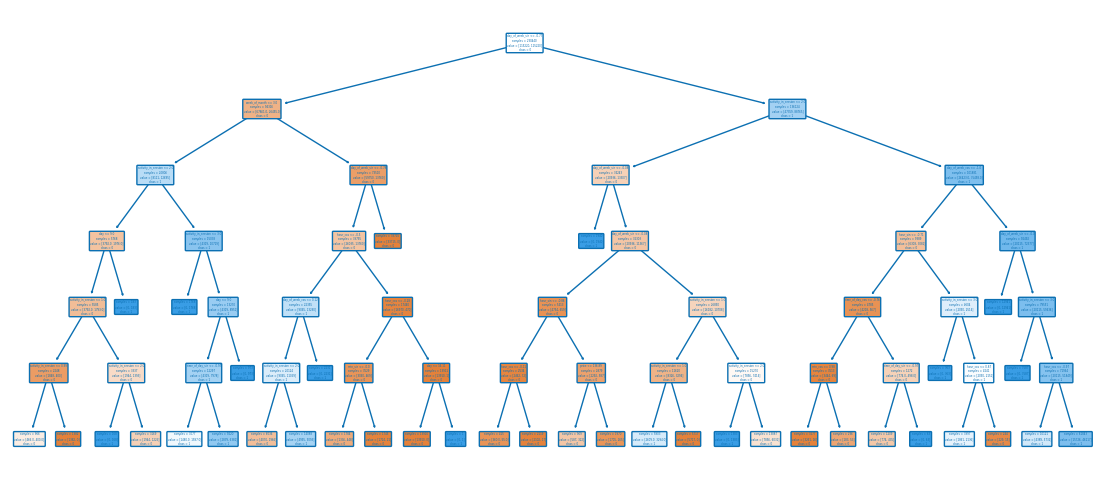

In [107]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model_f2,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")

show()

# Feature Importances

1. day_of_week_sin (0.42968882313872747)
2. activity_in_session (0.23438496252553206)
3. hour_cos (0.13506932860901177)
4. week_of_month (0.08929437236900993)
5. day_of_week_cos (0.06988997505625731)
6. hour_sin (0.016876030278651782)
7. day (0.008284747611047468)
8. time_of_day_cos (0.0074277785739928085)
9. min_sin (0.0035602146697821)
10. time_of_day_sin (0.002825415880206538)
11. min_cos (0.001520786230709489)
12. price (0.0011775650570712765)
13. brand_value (0.0)
14. is_weekend (0.0)


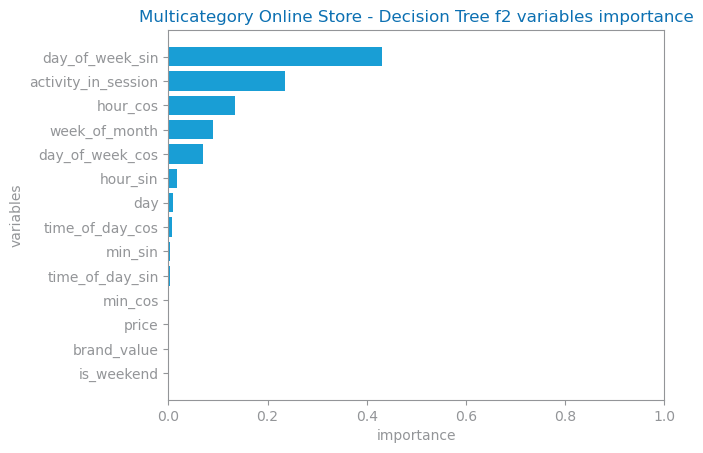

In [113]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_vars_ranking.png")
show()

# Overfitting

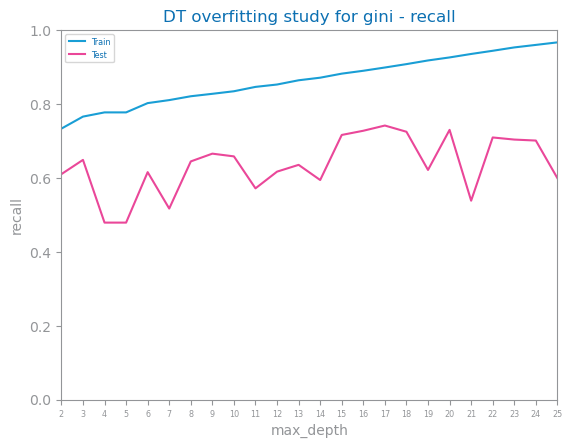

In [44]:
crit: Literal["entropy", "gini"] = params["params"][0]
d_max = 25
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
acc_metric = "accuracy"
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"DT overfitting study for {crit} - {eval_metric}",
    xlabel="max_depth",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{eval_metric}_overfitting.png")

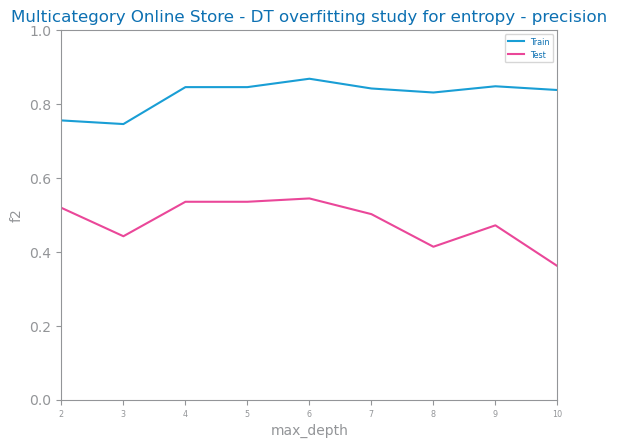

In [114]:
crit: Literal["entropy", "gini"] = f2_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} - DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(f2_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_overfitting.png")

# Precision Variables Importance

## precision tree evaluation

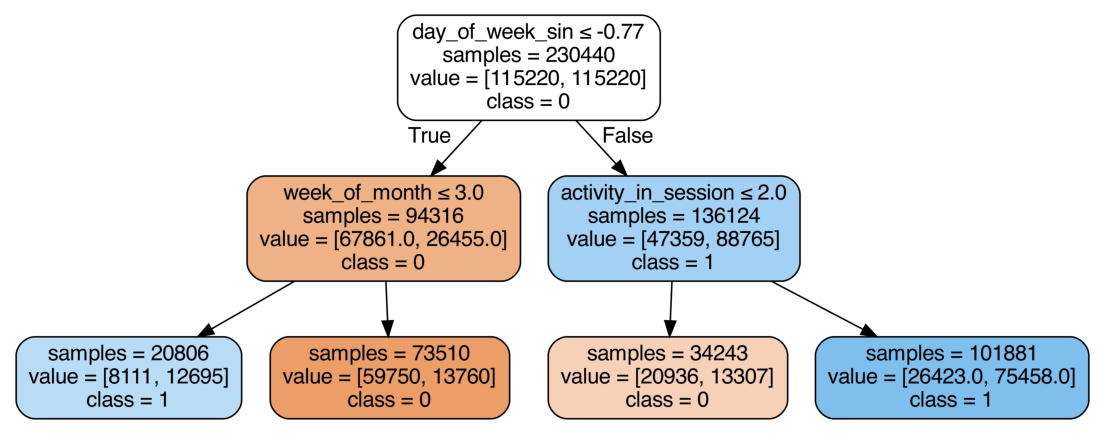

In [116]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{prec_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_prec,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
axis("off")
show()

## precision simple tree

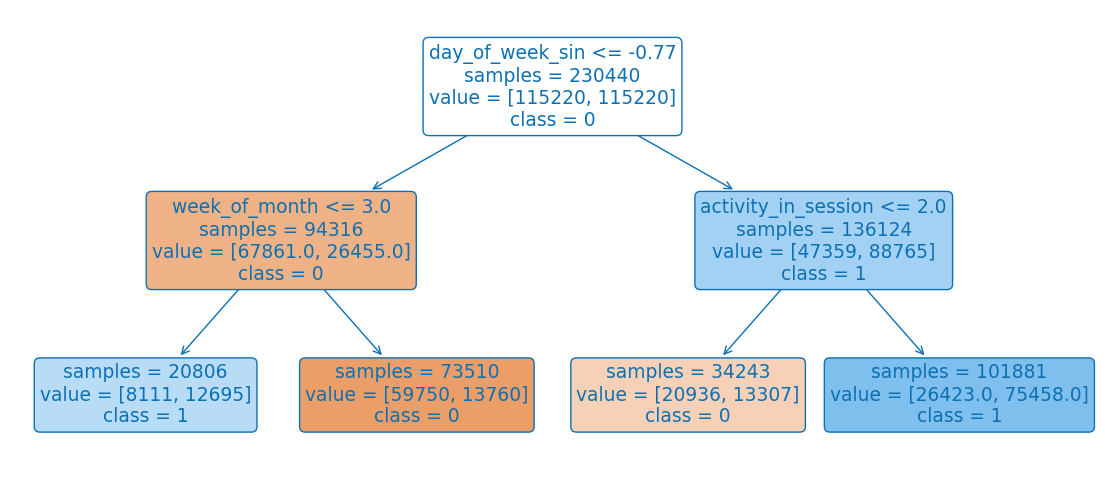

In [115]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model_prec,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")

show()

## precision feature importance

1. day_of_week_sin (0.5415553771185883)
2. activity_in_session (0.23173720321053287)
3. week_of_month (0.2267074196708788)
4. min_cos (0.0)
5. min_sin (0.0)
6. hour_cos (0.0)
7. hour_sin (0.0)
8. day_of_week_cos (0.0)
9. time_of_day_cos (0.0)
10. time_of_day_sin (0.0)
11. brand_value (0.0)
12. day (0.0)
13. is_weekend (0.0)
14. price (0.0)


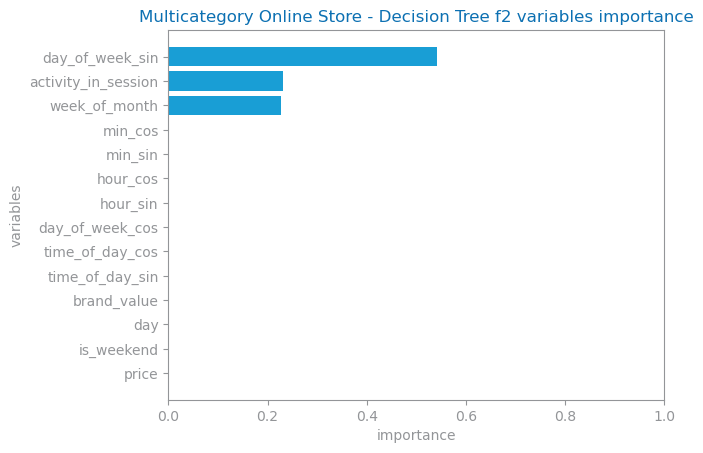

In [119]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} - Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_vars_ranking.png")
show()

## precision overfitting

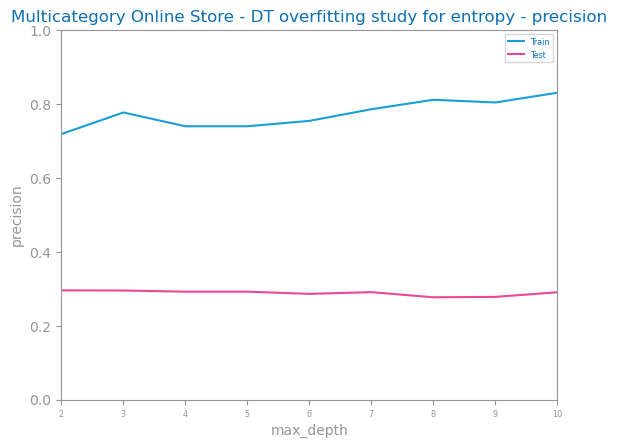

In [120]:
crit: Literal["entropy", "gini"] = prec_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} - DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(prec_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
